#### This model will be trained purely by resampling the dataset; i.e, the datasets will be balanced with some Gaussian noise added to the training set.

In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import neurokit2 as nk
import keras
import tensorflow  as tf
import keras_tuner
import seaborn as sns
import itertools
from sklearn.utils import resample
from keras.utils import to_categorical
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Add
from sklearn.metrics import confusion_matrix, classification_report

Loading the Dataset.

In [2]:
try:
    for dirname, _, filenames in os.walk('ECG/inputs/'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
except Exception as e:
    print(f"An error occurred: {e}")

ECG/inputs/dataECG\mitbih_test.csv
ECG/inputs/dataECG\mitbih_train.csv
ECG/inputs/dataECG\ptbdb_abnormal.csv
ECG/inputs/dataECG\ptbdb_normal.csv


Loading the training and test sets

In [3]:
train_data = pd.read_csv('ECG/inputs/dataECG/mitbih_train.csv', header=None)
test_data = pd.read_csv('ECG/inputs/dataECG/mitbih_test.csv',header=None)


In [4]:
train_target = train_data[187]
test_target  = test_data [187]
train = train_data.drop(187,axis=1)
test = test_data.drop(187,axis=1)

In [5]:
expl_mitbih_train = train_target.copy()
expl_mitbih_test = test_target.copy()

In [6]:
expl_train = expl_mitbih_train.astype(int)

explor_train = expl_train.value_counts()

Training set overview and class distribution.

In [7]:
train_dataset = train_data[187].value_counts()
print(train_dataset)

187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64


Overview of the test dataset.

In [8]:
test_dataset = test_data[187].value_counts()
print(test_dataset)

187
0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: count, dtype: int64


In [9]:
test_data.shape

(21892, 188)

`Dataset Balancing, by re-sampling the datasets.`

The training set is resampled such that each classes represented are in equal proportion.

In [10]:
data_sample1 = train_data[train_data[187] == 1]
data_sample2 = train_data[train_data[187] == 2]
data_sample3 = train_data[train_data[187] == 3]
data_sample4 = train_data[train_data[187] == 4]
data_sample0 = (train_data[train_data[187] == 0]).sample(n = 20000, random_state = 100)

In [11]:
data1_upsample = resample(data_sample1, replace = True, n_samples = 20000, random_state = 120)
data2_upsample = resample(data_sample2, replace = True, n_samples = 20000, random_state = 140)
data3_upsample = resample(data_sample3, replace = True, n_samples = 20000, random_state = 160)
data4_upsample = resample(data_sample4, replace = True, n_samples = 20000, random_state = 120)

In [12]:
train_sampled = pd.concat([data_sample0, data1_upsample, data2_upsample, data3_upsample, data4_upsample])

In [13]:
balanced_dataset = train_sampled[187].value_counts()
print(balanced_dataset)

187
0.0    20000
1.0    20000
2.0    20000
3.0    20000
4.0    20000
Name: count, dtype: int64


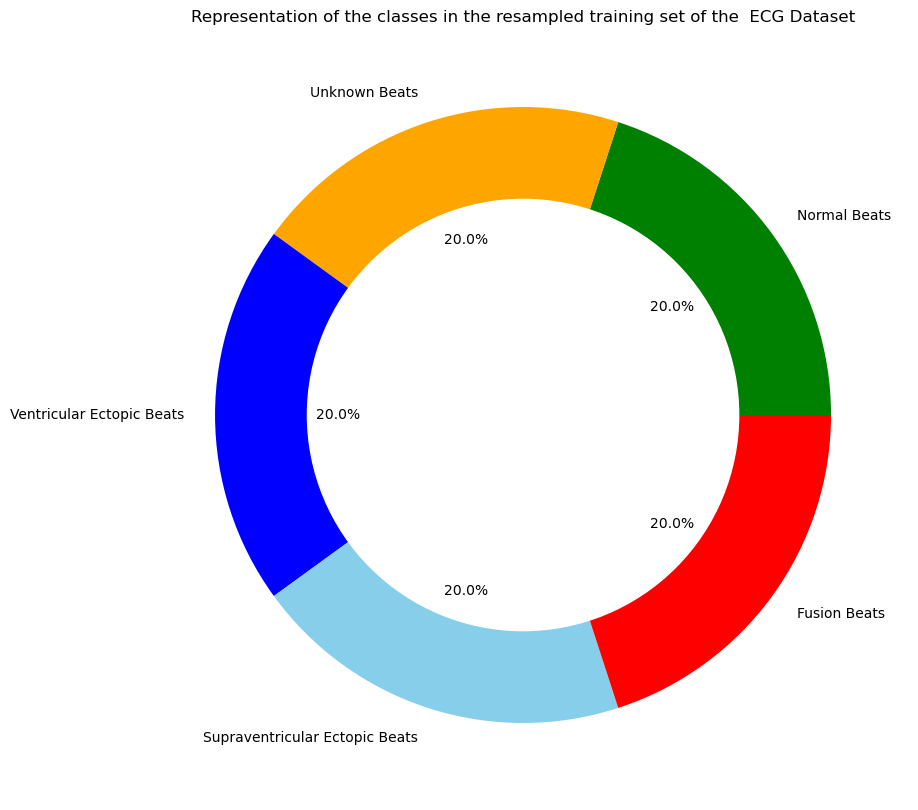

In [14]:
plt.figure(figsize = (10, 10))
circle = plt.Circle((0, 0), 0.7, color = "white")
plt.pie(balanced_dataset, labels = ["Normal Beats", "Unknown Beats", "Ventricular Ectopic Beats", "Supraventricular Ectopic Beats", "Fusion Beats"], colors = ["green", "orange", "blue", "skyblue", "red"], autopct = "%1.1f%%")
k = plt.gcf()
k.gca().add_artist(circle)
plt.title("Representation of the classes in the resampled training set of the  ECG Dataset")
plt.show()

In [15]:
classes = train_sampled.groupby(187, group_keys = False).apply(lambda train_sampled : train_sampled.sample(1))

In [16]:
classes

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
44892,0.987342,0.925633,0.392405,0.000000,0.153481,0.267405,0.283228,0.305380,0.305380,0.303797,...,0.253165,0.280063,0.289557,0.287975,0.303797,0.308544,0.297468,0.308544,0.310127,0.0
73812,1.000000,0.874214,0.125786,0.031447,0.150943,0.125786,0.025157,0.094340,0.201258,0.113208,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
79345,1.000000,0.910909,0.760000,0.501818,0.300000,0.240000,0.214545,0.185455,0.170909,0.160000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0
80800,1.000000,0.887344,0.668985,0.381085,0.123783,0.097357,0.101530,0.075104,0.066759,0.048679,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0
81308,0.933712,0.882576,0.816288,0.737689,0.623106,0.492424,0.370265,0.291667,0.227273,0.172348,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.0


In [17]:
x_train_sampled = train_sampled.iloc[ : ,  : 186].values
x_test = test_data.iloc[ : ,  : 186].values

In [18]:
x_train_sampled

array([[1.        , 0.6555773 , 0.17025441, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.83433735, 0.63554215, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.68154764, 0.09821428, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.90755355, 0.85569334, 0.79255921, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.57028115, 0.59437752, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.7161572 , 0.69432312, ..., 0.        , 0.        ,
        0.        ]])

In [19]:
x_test

array([[1.        , 0.75826448, 0.11157025, ..., 0.        , 0.        ,
        0.        ],
       [0.90842491, 0.7838828 , 0.53113556, ..., 0.        , 0.        ,
        0.        ],
       [0.73008847, 0.21238938, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.        , 0.96735907, 0.62017804, ..., 0.        , 0.        ,
        0.        ],
       [0.98412699, 0.5674603 , 0.60714287, ..., 0.        , 0.        ,
        0.        ],
       [0.97396964, 0.91323209, 0.86550975, ..., 0.        , 0.        ,
        0.        ]])

In [20]:
train_target = train_sampled[187]
#test_target = test_set[187]
test_target = test_data[187]

In [21]:
y_train_sampled = to_categorical(train_target)
y_test = to_categorical(test_target)

I will add a little Guassian Noise to the images just to help the model learn very well without over fitting.

* Generate the Gaussian noise.

In [22]:
np.random.seed (100)

def add_noise(signal):
    gaussian_noise = np.random.normal(0.2, 0.5, 186)
    noissy_signal = signal + gaussian_noise
    return noissy_signal

* ` NOTE: Noise is added to the sampled training set.`

In [23]:
for k in range(len(x_train_sampled)):
    x_train_sampled[k, : 186] = add_noise(x_train_sampled[k, : 186])
x_train_sampled = x_train_sampled.reshape(len(x_train_sampled), x_train_sampled.shape[1], 1)

x_test = x_test.reshape(len(x_test), x_test.shape[1], 1)


The Residual block

In [24]:
def residual_block(x, filters, kernel_size = 5, strides = 1):
    # Shortcut connection
    shortcut = x
    
    # First convolution layer
    x = Conv1D(filters, kernel_size = kernel_size, strides = strides, padding = "same", kernel_initializer = GlorotUniform())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second convolution layer
    x = Conv1D(filters, kernel_size = kernel_size, strides = strides, padding = "same", kernel_initializer = GlorotUniform())(x)
    x = BatchNormalization()(x)
    
    # Adjusting the shortcut connection with a 1x1 convolution
    shortcut = Conv1D(filters, kernel_size = 1, strides = strides, padding = "same")(shortcut)
    
    # Adding the shortcut to the main path
    x = Add()([x, shortcut])
    x = Activation("selu")(x)
    
    return x

In [25]:
input_shape = (x_train_sampled.shape)
class_num = len(classes)

In [26]:
class_num

5

In [27]:
input_shape = (x_train_sampled.shape[1], 1)

Model Architecture.

In [28]:
def build_model(hp):

    input_shape = (x_train_sampled.shape[1], 1)
    class_num = len(classes)
    model = tf.keras.Sequential()
    # Input layer
    input_layer = tf.keras.layers.Input(shape=input_shape)

    # Convolutional layers
    x = tf.keras.layers.Conv1D(
        filters = 64,
        kernel_size = 6,
        strides = 2,
        padding="same",
        kernel_initializer = tf.keras.initializers.GlorotUniform()
    )(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("selu")(x)
    x = tf.keras.layers.MaxPooling1D(pool_size = 3, padding = "same")(x)

    # Residual blocks
    for _ in range(hp.Int("num_residual_blocks", 2, 5)):
        x = residual_block(x, filters = 64)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling1D(pool_size = 2, padding = "same")(x)
        if hp.Boolean("Dropout_Residual_Blocks"):
            x = tf.keras.layers.Dropout(rate = 0.25)(x)

    for _ in range(hp.Int("num_residual_blocks", 2, 5)):
        x = residual_block(x, filters = 128)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling1D(pool_size = 2, padding = "same")(x)
        if hp.Boolean("Dropout_Residual_Blocks"):
            x = tf.keras.layers.Dropout(rate = 0.25)(x)

    x = residual_block(x, filters = 256)
    x = tf.keras.layers.MaxPooling1D(pool_size = 2, padding = "same")(x)

    # Flatten layer
    x = tf.keras.layers.Flatten()(x)

    # Dense layers
    for i in range(hp.Int("num_dense_layers", 1, 3)):
        x = tf.keras.layers.Dense(
            units = hp.Int(f"units_dense_{i}", min_value=32, max_value = 512, step = 32),
            activation = hp.Choice("activation_dense", ["relu", "selu"])
        )(x)
        if hp.Boolean("Dropout_Residual_Blocks"):
            x = tf.keras.layers.Dropout(rate = 0.25)(x)

    # Output layer
    model_output = tf.keras.layers.Dense(class_num, activation = "softmax")(x)

    # Compile the model
    model = tf.keras.Model(inputs = input_layer, outputs = model_output)
    learning_rate = hp.Float("learning_rate", min_value = 1e-4, max_value = 2e-2, sampling = "log")
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss = "categorical_crossentropy",
        metrics = ["accuracy"]
    )
    return model


In [29]:
build_model(keras_tuner.HyperParameters())

In [30]:
input_shape = (x_train_sampled.shape[1], 1)

In [31]:
class_num

5

In [32]:
tuner = keras_tuner.RandomSearch(
    hypermodel = build_model,
    objective = "val_accuracy",
    max_trials = 4,
    executions_per_trial = 2,
    overwrite = True,
    directory = "./",
    project_name = "mitbih_tuned",
)

In [33]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
num_residual_blocks (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
Dropout_Residual_Blocks (Boolean)
{'default': False, 'conditions': []}
num_dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_dense_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation_dense (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'selu'], 'ordered': False}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.02, 'step': None, 'sampling': 'log'}


In [34]:
tuner.search(
    x_train_sampled, y_train_sampled, 
    epochs = 3, 
    validation_data = (x_test, y_test),
    callbacks = [keras.callbacks.TensorBoard("./tbb2_logs")]
    )

Trial 4 Complete [00h 17m 49s]
val_accuracy: 0.7525351643562317

Best val_accuracy So Far: 0.7525351643562317
Total elapsed time: 01h 26m 42s


In [35]:
%load_ext tensorboard

%tensorboard --logdir ./tbb2_logs

Reusing TensorBoard on port 6006 (pid 28640), started 1 day, 8:34:52 ago. (Use '!kill 28640' to kill it.)

In [36]:
models = tuner.get_best_models(num_models = 2)
best_model = models[0]

In [37]:
tuner.results_summary()

Results summary
Results in ./mitbih_tuned
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 3 summary
Hyperparameters:
num_residual_blocks: 3
Dropout_Residual_Blocks: False
num_dense_layers: 3
units_dense_0: 32
activation_dense: selu
learning_rate: 0.0005577111793917841
units_dense_1: 448
units_dense_2: 192
Score: 0.7525351643562317

Trial 2 summary
Hyperparameters:
num_residual_blocks: 4
Dropout_Residual_Blocks: False
num_dense_layers: 2
units_dense_0: 352
activation_dense: selu
learning_rate: 0.0004883404151206104
units_dense_1: 64
units_dense_2: 192
Score: 0.6863922774791718

Trial 0 summary
Hyperparameters:
num_residual_blocks: 5
Dropout_Residual_Blocks: False
num_dense_layers: 3
units_dense_0: 192
activation_dense: relu
learning_rate: 0.003862791478469442
units_dense_1: 32
units_dense_2: 32
Score: 0.6822583675384521

Trial 1 summary
Hyperparameters:
num_residual_blocks: 5
Dropout_Residual_Blocks: False
num_dense_layers: 2
units_dense_0: 288
activation_d

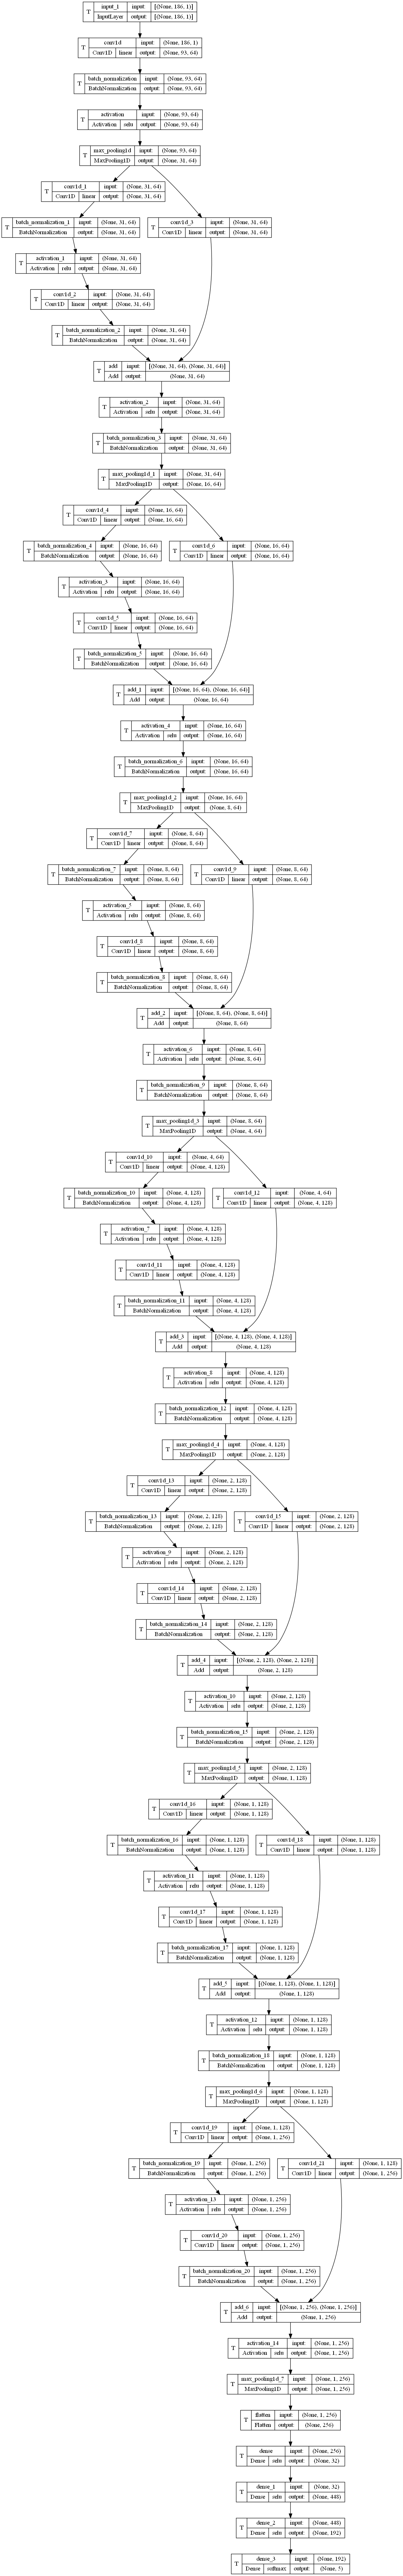

In [38]:
tf.keras.utils.plot_model(best_model,
                          to_file='modelv04.png', 
                          show_layer_names=True,
                          show_layer_activations = True,
                          show_trainable = True,
                          show_shapes = True,
                          dpi=96)

In [39]:
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 186, 1)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 93, 64)               448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 93, 64)               256       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 93, 64)               0         ['batch_normalization[0][0

`Train Best Model with the datasets`

In [40]:
history = best_model.fit(
    x_train_sampled, y_train_sampled, 
    epochs = 10, 
    validation_data = (x_test, y_test),
    batch_size = 32,
    callbacks = [keras.callbacks.TensorBoard("./tbb2_logs")]
    )

Epoch 1/10
3125/3125 [==============================] - 232s 63ms/step - loss: 0.8588 - accuracy: 0.6772 - val_loss: 1.0536 - val_accuracy: 0.5930
Epoch 2/10
3125/3125 [==============================] - 196s 63ms/step - loss: 0.8168 - accuracy: 0.6939 - val_loss: 0.9810 - val_accuracy: 0.7083
Epoch 3/10
3125/3125 [==============================] - 193s 62ms/step - loss: 0.7852 - accuracy: 0.7054 - val_loss: 1.2345 - val_accuracy: 0.3203
Epoch 4/10
3125/3125 [==============================] - 144s 46ms/step - loss: 0.7603 - accuracy: 0.7149 - val_loss: 0.8034 - val_accuracy: 0.7336
Epoch 5/10
3125/3125 [==============================] - 153s 49ms/step - loss: 0.7404 - accuracy: 0.7240 - val_loss: 0.6942 - val_accuracy: 0.8272
Epoch 6/10
3125/3125 [==============================] - 157s 50ms/step - loss: 0.7188 - accuracy: 0.7322 - val_loss: 0.8753 - val_accuracy: 0.6576
Epoch 7/10
3125/3125 [==============================] - 163s 52ms/step - loss: 0.6967 - accuracy: 0.7399 - val_loss: 1

Model performance plots.

In [41]:
def model_plots(history):
    """ This function plots the model accuracy and loss. """
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Model Accuracy")
    plt.legend(["Train", "Validation"], loc = "upper left")
    plt.show()


    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Model Loss")
    plt.legend(["Train", "Validation"], loc = "upper left")
    plt.show()

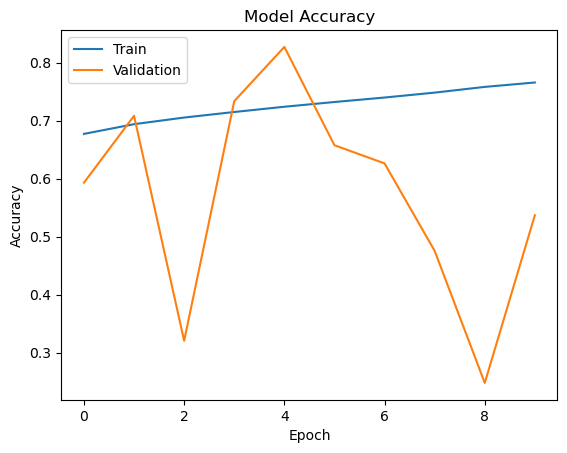

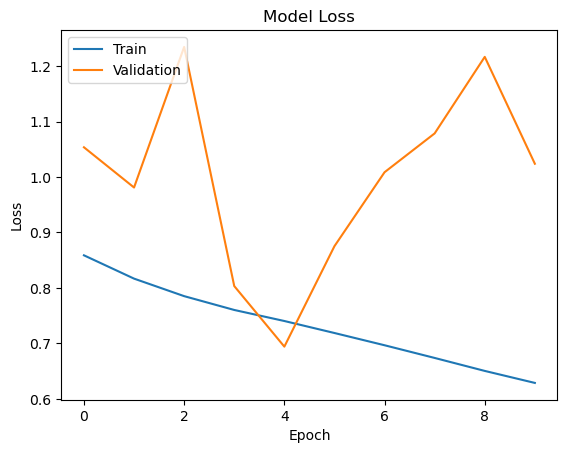

In [42]:
model_plots(history = history)

In [43]:
loss, accuracy = best_model.evaluate(x_test, y_test)
print(f"Test Accuracy is: {accuracy} and Test Loss is: {loss}")

685/685 [==============================] - 12s 17ms/step - loss: 1.0239 - accuracy: 0.5369
Test Accuracy is: 0.5368627905845642 and Test Loss is: 1.0238879919052124


In [44]:
y_pred = best_model.predict(x_test)

685/685 [==============================] - 13s 16ms/step


In [45]:

def plot_confusion_matrix (model, x_test, y_test, class_names):
    y_pred_classes = np.argmax(y_pred, axis = 1)
    conf_matrix = confusion_matrix(np.argmax(y_test, axis = 1), y_pred_classes)

    plt.figure(figsize = (10, 10))
    sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "YlGnBu", xticklabels = class_names, yticklabels = class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix")
    plt.show()

    print(classification_report(np.argmax(y_test, axis = 1), y_pred_classes, target_names = class_names))

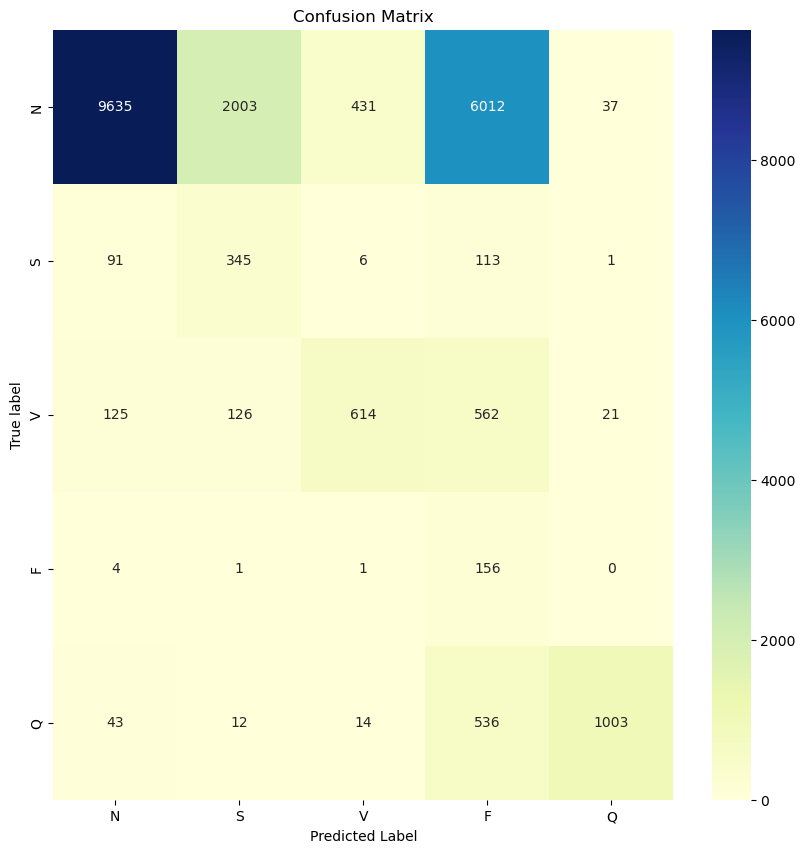

              precision    recall  f1-score   support

           N       0.97      0.53      0.69     18118
           S       0.14      0.62      0.23       556
           V       0.58      0.42      0.49      1448
           F       0.02      0.96      0.04       162
           Q       0.94      0.62      0.75      1608

    accuracy                           0.54     21892
   macro avg       0.53      0.63      0.44     21892
weighted avg       0.92      0.54      0.66     21892



In [46]:
class_names = ["N", "S", "V", "F", "Q"]

plot_confusion_matrix(best_model, x_test, y_test, class_names)

In [47]:
def plot_confusion_matrix(classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    y_pred_classes = np.argmax(y_pred, axis = 1)
    conf_matrix = confusion_matrix(y_test.argmax(axis = 1), y_pred.argmax(axis = 1))
    np.set_printoptions(precision = 2)
    
    if normalize:
        cm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    
    
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation = "nearest", cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    
    print(classification_report(np.argmax(y_test, axis = 1), y_pred_classes, target_names = class_names))


Normalized confusion matrix


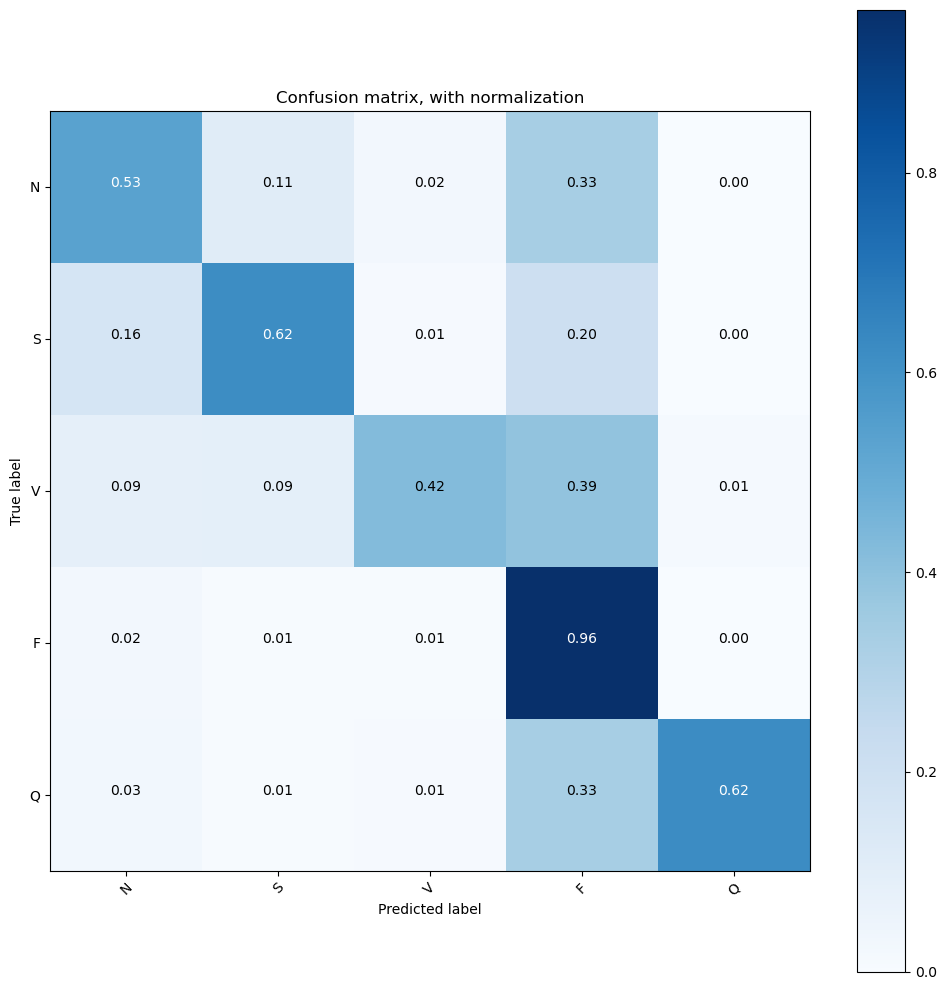

              precision    recall  f1-score   support

           N       0.97      0.53      0.69     18118
           S       0.14      0.62      0.23       556
           V       0.58      0.42      0.49      1448
           F       0.02      0.96      0.04       162
           Q       0.94      0.62      0.75      1608

    accuracy                           0.54     21892
   macro avg       0.53      0.63      0.44     21892
weighted avg       0.92      0.54      0.66     21892



In [48]:
plot_confusion_matrix(classes = class_names, normalize = True,
                      title="Confusion matrix, with normalization")


`Safe the Best Model`

In [49]:
model_dir = "trained_models"

if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
best_model.save(os.path.join(model_dir, "projectv04Model.h5"))

c:\Users\DELL\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [50]:
# To load the model in future;

#loaded_model = tf.keras.models.load_model(os.path.join(model_dir, "projectv02aModel.h5"))